# Obtain all necessary imports

In [1]:
from IPython import get_ipython;   
get_ipython().magic('reset -sf') # Clear the variables present on the namespace

import numpy as np
import random
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd
import peakutils

from numpy import dot, multiply, diag, power
from IPython.display import HTML
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.integrate import simps
from matplotlib.animation import FuncAnimation
from matplotlib import colors
from matplotlib import animation

# Create the pouch class and pouch operations

In [2]:
scalingPower = -0.8
scalingCoeff = 8000

In [3]:
class Pouch(object): 
    def __init__(self, params=None, size = 'xsmall', sim_number=0, save=False, saveName='default'):
        
        """Class implementing pouch structure and simulating Calcium signaling.
        Inputs:
        
        params (dict)
            A Python dictionary of parameters to simulate with the keys:
            ['K_PLC', 'K_5', 'k_1' , 'k_a', 'k_p', 'k_2', 'V_SERCA', 'K_SERCA', 'c_tot', 'beta', 'k_i', 'D_p', 'tau_max', 'k_tau', 'lower', 'upper','frac', 'D_c_ratio']
        
        size (string)
            Size of the pouch to simulate:
            [xsmall, small, medium, or large]
            if tuple, then it should be in the form of (a,b,r)
            x/a**2 + y/b**2 < r
            0 < r < 1
            a: Horizontal stretch
            b: Vertical stretch
        
        sim_number (integer)
            Represents ID of a simulation to save the figures with unique names and set the random number generator seed
        
        save (boolean)
            If True, the simulation outputs will be saved
        
        saveName (string)
            Additional distinct name to save the output files as
        
        """
        # Create characteristics of the pouch object
        self.size=size # The size of the simulated pouch
        self.saveName=saveName # Appendage to save file name
        self.sim_number=sim_number # Used for the random number generator seed
        self.save=save # Used to determine whether or not we will be saving the output
        self.param_dict=params # Parameters passed into the differential equations
        
        # If parameters are not set, then use baseline values
        if self.param_dict==None:
            self.param_dict={'K_PLC': 0.2, 'K_5':0.66, 'k_1':1.11 , 'k_a': 0.08, 'k_p':0.13, 'k_2':0.0203, 'V_SERCA':0.9, 'K_SERCA':0.1,
            'c_tot':2, 'beta':.185, 'k_i':0.4, 'D_p':0.005, 'tau_max':800, 'k_tau':1, 'lower':0.5, 'upper':0.7,'frac':0.007680491551459293, 'D_c_ratio':0.1}
        
        # If a dictionary is given, assure all parameters are provided
        if sorted([r for r in self.param_dict])!=['D_c_ratio','D_p','K_5','K_PLC','K_SERCA','V_SERCA','beta','c_tot','frac','k_1','k_2', 'k_a', 'k_i','k_p','k_tau','lower','tau_max','upper']:
            print("Improper parameter input, please assure all parameters are specified")
            return
            
        # Load statics for wing disc geometries    
        disc_vertices=np.load("./geometry/disc_vertices.npy",allow_pickle=True).item() # Vertices
        disc_laplacians=np.load("./geometry/disc_sizes_laplacian.npy",allow_pickle=True).item() # Laplacian Matrix
        disc_adjs=np.load("./geometry/disc_sizes_adj.npy",allow_pickle=True).item() # Adjacency matrix
        adj_length_matrix=np.load("./geometry/adj_length_matrix.npy",allow_pickle=True)
        self.orig_disc_vertices=disc_vertices['large'] 
        
        # If size argument is a string, then obtain either "large", "medium", "small" or "xsmall" wing template matrices
        # Else, the argument should be a tuple to adjust the tissue size
        if isinstance(self.size,str):
            self.adj_matrix= disc_adjs[self.size]
            self.laplacian_matrix=disc_laplacians[size]
            self.new_vertices=disc_vertices[size]
            self.sizeHint=self.size
            self.sizeSave = self.size
        elif isinstance(self.size,tuple):
            self.sizeHint= 'custom'
            self.sizeSave = ''.join(map(str,[round(self.size[0],5),"_",round(self.size[1],5),"_",round(self.size[2],5)])) # Used to save files names with input size parameters
            a,b,r= self.size
            adj_matrix= disc_adjs['large']
            new_vertices=disc_vertices['large']
            
            # Create the adjusted pouch size based off the "large" template
            custom_pouch_index=[]
            centeriods= np.zeros((adj_matrix.shape[0],2))
            for j in range(adj_matrix.shape[0]):
                x_center, y_center=new_vertices[j].mean(axis=0)
                centeriods[j,0],centeriods[j,1]=x_center, y_center
                if (x_center-800)**2/float(a)+(y_center+500)**2/float(b)<r*100000:
                    custom_pouch_index.append(j)
            custom_pouch_index=np.array(custom_pouch_index)
            self.new_vertices=new_vertices[custom_pouch_index]

            adj_length_matrix_custom=adj_length_matrix[custom_pouch_index,:]
            adj_length_matrix_custom=adj_length_matrix_custom[:,custom_pouch_index]

            self.laplacian_matrix=np.copy(adj_length_matrix_custom)

            for j in range(adj_length_matrix_custom.shape[0]):
                self.laplacian_matrix[j,j]=-1.0*np.sum(adj_length_matrix_custom[j,:])
            self.adj_matrix= (self.laplacian_matrix>0).astype(int)
        else:
            print('Enter correct size format as a tuple (a,b,r)')
            return
        
        # Establish characteristics of the pouch for simulations
        self.n_cells=self.adj_matrix.shape[0] # Number of cells in the pouch
        self.dt=.2 # Time step for ODE approximations
        self.T=int(3600/self.dt) # Simulation to run for 3600 seconds (1 hour) 
        
        # Establish baseline parameter values for the simulation
        self.K_PLC=self.param_dict['K_PLC']  # .2
        self.K_5=self.param_dict['K_5'] # 0.66
        self.k_1=self.param_dict['k_1'] # 1.11
        self.k_a=self.param_dict['k_a'] # 0.08
        self.k_p=self.param_dict['k_p'] # 0.13
        self.k_2=self.param_dict['k_2'] # 0.0203
        self.V_SERCA=self.param_dict['V_SERCA'] # .9
        self.K_SERCA=self.param_dict['K_SERCA'] # .1
        self.c_tot=self.param_dict['c_tot'] # 2
        self.beta=self.param_dict['beta'] # .185
        self.k_i=self.param_dict['k_i'] # 0.4
        self.D_p =self.param_dict['D_p'] # 0.005
        self.D_c =self.param_dict['D_c_ratio']*self.D_p
        self.tau_max=self.param_dict['tau_max'] # 800
        self.k_tau=self.param_dict['k_tau'] # 1.5
        self.lower=self.param_dict['lower'] # Lower bound of standby cell VPLCs
        self.upper=self.param_dict['upper'] # Upper bound of standy cell VPLCs
        self.frac=scalingCoeff*self.n_cells**(scalingPower-1) # Fraction of initiator cells
        
        self.disc_dynamics=np.zeros((self.n_cells,4,self.T)) # Initialize disc_dynamics to save simulation calcium, IP3, calcium_ER, ratio. All start at a value of 0.
        self.VPLC_state=np.zeros((self.n_cells,1)) # Initialize VPLC array for cells. All start at a value of 0.
        self.initiatorCellCount = int((self.frac*self.n_cells))


    """Pouch method to draw the tissue shape.
    Inputs:
    
    with_original_shape (boolean)
        If True, plot will allow an overlay of the template 'large' disc for comparison
    """
    def draw(self, with_original_shape=False):
        with sns.axes_style("white"):
            fig=plt.figure(figsize=(15,10))
            ax = fig.add_subplot(1,1,1)
            ax.set_ylim([-950,-50])
            ax.set_xlim([100,1400])
            for cell in self.new_vertices:
                ax.plot(cell[:,0],cell[:,1], linewidth=1.0, color='k')
                ax.plot([cell[-1,0],cell[0,0]],[cell[-1,1],cell[0,1]], linewidth=1.0, color='k')
                if with_original_shape:
                    ax.fill(cell[:,0],cell[:,1], 'b', alpha=.2)
            if with_original_shape:
                for cell in self.orig_disc_vertices:
                    ax.plot(cell[:,0],cell[:,1], linewidth=1.0, color='k')
                    ax.plot([cell[-1,0],cell[0,0]],[cell[-1,1],cell[0,1]], linewidth=1.0, color='k')

    """Pouch method to simulate the dynamics of the system."""
    def simulate(self):
            np.random.seed(self.sim_number) # Set the seed for reproducibility (keep initiator cells consistent each run)
            
            self.disc_dynamics[:,0,0] = np.random.uniform(.055,.059,size=(self.n_cells,1)).T # Initialize the calcium simulation levels for all cells to be random uniformly distributed from 0.055 to 0.059 at t = 0
            self.disc_dynamics[:,1,0] = np.random.uniform(0.07, 0.09,size=(self.n_cells,1)).T # Initialize the IP3 simulation levels for all cells to be random uniformly distributed from 0.07 to 0.09 at t = 0
            self.disc_dynamics[:,2,0] = (self.c_tot-self.disc_dynamics[:,0,0])/self.beta # Initialize simulation ER Calcium at t = 0
            self.disc_dynamics[:,3,0] = np.random.uniform(.5,.7,size=(self.n_cells,1)).T # Initialize simulation fraction of inactivated IP3R receptors to be random uniformly distributed from 0.5 to 0.7 at t = 0
            self.VPLC_state=np.random.uniform(self.lower,self.upper,(self.n_cells,1)) # Initialize the values for VPLCs of standby cells to be random uniformly distributed from lower to upper
            stimulated_cell_idxs=np.random.choice(self.n_cells, self.initiatorCellCount) # Choose which cells are initiator cells
            
            # If the fraction parameter is too small such that there are no initiator cells, then set at least one cell to be an initiator
            if len(stimulated_cell_idxs) == 0:
                stimulated_cell_idxs = [1]
            self.VPLC_state[stimulated_cell_idxs,0]=np.random.uniform(1.3,1.5,len(stimulated_cell_idxs)) # Set the VPLC of initiator cells to be random uniformly distributed between 1.3 and 1.5
            
            V_PLC=self.VPLC_state.reshape((self.n_cells,1)) # Establish the VPLCs to be passed into the ODE approximations
            
            # ODE approximation solving
            for step in range(1,self.T):
                # ARRAY REFORMATTING
                ca=self.disc_dynamics[:,0,step-1].reshape(-1,1)
                ipt=self.disc_dynamics[:,1,step-1].reshape(-1,1)
                s=self.disc_dynamics[:,2,step-1].reshape(-1,1)
                r=self.disc_dynamics[:,3,step-1].reshape(-1,1)
                ca_laplacian=self.D_c*np.dot(self.laplacian_matrix,ca)
                ipt_laplacian=self.D_p*np.dot(self.laplacian_matrix,ipt)
                
                # ODE EQUATIONS
                self.disc_dynamics[:,0,step]=(ca+self.dt*(ca_laplacian+ (self.k_1*( np.divide(np.divide(r*np.multiply(ca,ipt),(self.k_a+ca)),(self.k_p+ipt)) )**3 +self.k_2 )*(s-ca) -self.V_SERCA*(ca**2)/(ca**2+ self.K_SERCA**2) )).T
                self.disc_dynamics[:,1,step]=(ipt+self.dt*(ipt_laplacian+ np.multiply(V_PLC,np.divide(ca**2,(ca**2+ self.K_PLC**2)))  -  self.K_5*ipt )).T
                self.disc_dynamics[:,2,step]=((self.c_tot-ca)/self.beta).T
                self.disc_dynamics[:,3,step]=(r+self.dt*((self.k_tau**4+ca**4)/(self.tau_max*self.k_tau**4))*(( 1-r*(self.k_i+ca)/self.k_i))).T
            
    """Pouch method to make an output .mp4 file."""
    def make_animation(self, path=None):
        colormap = plt.cm.Greens
        normalize = matplotlib.colors.Normalize(vmin=np.min(self.disc_dynamics[:,0,:]), vmax=max(np.max(self.disc_dynamics[:,0,:]),1))
        with sns.axes_style("white"):
                fig=plt.figure(figsize=(25,15))
                fig.patch.set_alpha(0.)
                ax = fig.add_subplot(1,1,1)
                ax.axis('off')
                sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
                sm._A = []
                cbar=fig.colorbar(sm, ax=ax)
                cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=15,fontweight="bold")
                for cell in self.new_vertices:
                    ax.plot(cell[:,0],cell[:,1], linewidth=0.0, color='w', alpha = 0.0)
                patches = [matplotlib.patches.Polygon(verts) for verts in self.new_vertices ]
                def time_stamp_gen(n):
                    j=0
                    while j < n: # 0.2 sec interval to 1 hour time lapse
                        yield "Elapsed time: "+'{0:02.0f}:{1:02.0f}'.format(*divmod(j*self.dt , 60))
                        j+= 50
                time_stamps=time_stamp_gen(self.T)
                def init():
                    return [ax.add_patch(p) for p in patches]

                def animate(frame,time_stamps):
                    for j in range(len(patches)):
                        c=colors.to_hex(colormap(normalize(frame[j])), keep_alpha=False)
                        patches[j].set_facecolor(c)
                    ax.set_title( next(time_stamps) ,fontsize=50, fontweight="bold")
                    return patches

                anim = animation.FuncAnimation(fig, animate, 
                                               init_func=init, 
                                               frames=self.disc_dynamics[:,0,::50].T, # Output calcium signal every 50 time steps
                                               fargs=(time_stamps,),
                                               interval=70,
                                               blit=True)
        if self.save:
            if path!=None:
                if not os.path.exists(path):
                    os.makedirs(path)
                anim.save(path+"/"+self.sizeSave+'_Disc_'+str(self.sim_number)+'_'+self.saveName+'.mp4')
            else:
                print("Provide a path for saving videos")
        
    """Pouch method to draw the VPLC Profile for the simulation.
    Inputs: 
    
    path (string)
        The path of where the output figure is to be saved
    """
    def draw_profile(self, path=None):
        colormap = plt.cm.Blues
        normalize = matplotlib.colors.Normalize(vmin=.0, vmax=1.5)
        with sns.axes_style("white"):
                fig=plt.figure(figsize=(45,25))
                ax = fig.add_subplot(1,1,1)
                ax.axis('off')
                fig.patch.set_alpha(0.)
                sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
                sm._A = []
                cbar=fig.colorbar(sm, ax=ax)
                cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=80,fontweight="bold" )
                for cell in self.new_vertices:
                    ax.plot(cell[:,0],cell[:,1], linewidth=1.0, color='k')
                for k in range(len(self.new_vertices)):
                        cell=self.new_vertices[k]
                        c=colors.to_hex(colormap(normalize(self.VPLC_state[k]))[0], keep_alpha=False)
                        ax.fill(cell[:,0],cell[:,1], c)

        if self.save:
            if path!=None:
                if not os.path.exists(path):
                    os.makedirs(path)
                fig.savefig(path+"/"+self.sizeSave+'_VPLC_'+str(self.sim_number)+'_'+self.saveName+".png",transparent=True, bbox_inches="tight")
            else:
                print("Provide a path for saving images")
    
    """Pouch method to draw the calcium simulation 2D kymograph."""
    def draw_kymograph(self, path=None, kymograph_location = -490):
        with sns.axes_style("white"):
            centeriods= np.zeros((self.adj_matrix.shape[0],2))
            for j in range(self.adj_matrix.shape[0]):
                x_center, y_center=self.new_vertices[j].mean(axis=0)
                centeriods[j,0],centeriods[j,1]=x_center, y_center
            y_axis=centeriods[:,1]
            kymograp_index=np.where((y_axis<(kymograph_location)) & (y_axis>(kymograph_location-20)))

            colormap = plt.cm.Greens
            normalize = matplotlib.colors.Normalize(vmin=np.min(self.disc_dynamics[:,0,:]), vmax=max(1,np.max(self.disc_dynamics[:,0,:])))
            fig=plt.figure(figsize=(30,10))
            kymograph=self.disc_dynamics[kymograp_index,0,::][0][:,::2]
            kymograph=np.repeat(kymograph,60,axis=0)

            plt.imshow(kymograph.T,cmap=colormap,norm=normalize)
            ax = plt.gca()
            plt.yticks(np.arange(0,self.T/2,1498) , [0,10,20,30,40,50,60],fontsize=30, fontweight="bold")
            plt.xticks([])
            plt.ylabel('Time (min)',fontsize=30,fontweight='bold')
            if self.size=='xsamll':
                plt.xlabel('Position',fontsize=20,fontweight='bold')
            else:
                plt.xlabel('Position',fontsize=30,fontweight='bold')

            if self.save:
                if path!=None:
                    if not os.path.exists(path):
                        os.makedirs(path)
                    fig.savefig(path+"/"+self.sizeSave+'_Kymograph_'+str(self.sim_number)+'_'+self.saveName+".png",transparent=True, bbox_inches="tight")
                else:
                    print("Provide a path for saving images")

        del kymograph
    
    """Pouch method to obtain signal dynamics of cells above/below a certain threshold.
    
    Inputs:
    
    threshold (float)
        The baseline threshold to filter cells that do not have a signal value above the threshold
    
    whichSignal (string)
        Used to determine if we want 'Calcium', 'IP3', 'ER Calcium', or 'IP3R' signaling dynamics
    
    wantSignal (boolean)
        If True, returns all cells in the pouch with a signal above the threshold.
        If False, returns all cells in the pouch below the signal threshold
    """
    def getSignalCells(self, threshold = 0.06, whichSignal = 'Calcium', wantSignal = True):
        if whichSignal == 'Calcium':
            selector = 0
        elif whichSignal == 'IP3':
            selector = 1
        elif whichSignal == 'ER Calcium':
            selector = 2
        elif whichSignal == 'IP3R':
            selector = 3
        else:
            selector = 0

        VPLCdf = pd.DataFrame(self.VPLC_state) # Obtain the pouch VPLCs
        VPLCdf.rename(columns={VPLCdf.columns[-1]: "VPLC" }, inplace = True) # Rename the dataframe column to "VPLC"
        temp = pd.concat([pd.DataFrame(self.disc_dynamics[:,selector,:]), VPLCdf], axis=1)
        signalsIndex = []
        nonSignalsIndex = []

        checkSignal = temp.iloc[:,0:-1].mean(axis=1)
        
        for i in range(0, self.n_cells):
            if checkSignal[i] >= threshold:
                signalsIndex.append(i)
            else:
                nonSignalsIndex.append(i)

        signalCells = temp.iloc[signalsIndex]
        nonSignalCells = temp.iloc[nonSignalsIndex]
        if wantSignal:
            return signalCells
        else:
            return nonSignalCells
        
    """Pouch method to obtain the baseline signal of a simulation output.
    Inputs:
    
    whichSignal (string)
        Used to determine if we want 'Calcium', 'IP3', 'ER Calcium', or 'IP3R' signaling dynamics
    """
    def getBaselineSignal(self, whichSignal = 'Calcium'):
         return 1.05*peakutils.baseline(self.getSignalCells(threshold = 0.00, whichSignal = whichSignal, wantSignal = True).iloc[:,:-1].mean()).mean()
            
    """Pouch method to plot the frequency width at half-maximum (FWHM) for a desired signal type.
    Inputs:
    
    peakWidthDist (Integer)
        Increase or decrease the range to search for peaks in the signal 
    
    typeActivity (string)
        String to be passed into the plotting title
    
    whichSignal (string)
        Used to determine if we want 'Calcium', 'IP3', 'ER Calcium', or 'IP3R' signaling dynamics
    
    baselineThreshold (string or float)
        (string) By inputting 'auto', the getBaselineSignal() method is called to obtain the baseline threshold
        (float) This is passed into the getSignalCells() method to filter out cells
    
    getStats (boolean)
        If True, prints out the signal statistics for:
            Minimum intensity, maximum intensity, median peak intensity, number of peaks, median FWHM, median frequency, and integrated intensity
    
    path (string)
        The path of where the output figure is to be saved
    """
    def plotFWHM(self, plotLim, peakWidthDist = 100, typeActivity = 'Spike', whichSignal = 'Calcium', baselineThreshold = 'auto', getStats = True, saveFig = False, path = './testResults/cellSizeControl', outputPlot = True):
        if baselineThreshold == 'auto':
            baselineThreshold = self.getBaselineSignal(whichSignal = whichSignal)
        else:
            baselineThreshold = baselineThreshold
        signaling = self.getSignalCells(threshold = baselineThreshold, whichSignal = whichSignal).iloc[:,1:-1] # Signaling Cells. 1:-1 selects time steps but not the VPLC value
        nonSignaling = self.getSignalCells(threshold = baselineThreshold, whichSignal = whichSignal, wantSignal = False).iloc[:,1:-1] # Non-Spiking Cells. 1:-1 selects time steps but not the VPLC value
        a = pd.DataFrame(signaling.iloc[:,:-1].mean().transpose())
        a = a.rename(columns={0: 'signal'})
        b = pd.DataFrame(nonSignaling.iloc[:,:-1].mean().transpose())
        b = b.rename(columns={0: 'nosignal'})
        b['Time (s)'] = b.index.to_frame()*0.2
        concat = pd.concat([a,b], axis=1)

        peakIndexes = list(find_peaks(concat['signal'][0:], distance=peakWidthDist))[0]
        peaksPlot = concat.sort_index().loc[peakIndexes]
        nPeaks = len(peakIndexes)
        minimumIntensity = concat['signal'].min()
        maximumIntensity = concat['signal'].max()
        medPeakIntensity = peaksPlot['signal'].median()

        getPeakWidths = peak_widths(concat['signal'][0:], peakIndexes, rel_height=0.5)
        WHM = [[x*0.2 for x in y] for y in getPeakWidths]
        WHM[1] = [x/0.2 for x in WHM[1]]
        FWHM = WHM[0]
        medianFWHM = pd.DataFrame(FWHM).median()[0]

        period = []
        for i in range(0,nPeaks-1):
            period.append(peaksPlot['Time (s)'].iloc[i+1] - peaksPlot['Time (s)'].iloc[i])
        freq = 1/pd.DataFrame(period).median()[0]
        fullFreq = 1/pd.DataFrame(period)

        integratedInt = simps(concat['signal'], dx=self.dt)

        stdErrMedPeak = 1.96 * 1.2533 * peaksPlot['signal'].std() / np.sqrt(len(peaksPlot['signal']))
        stdErrMedFWHM = 1.96 * 1.2533 * pd.DataFrame(FWHM).std() / np.sqrt(len(pd.DataFrame(FWHM)))
        stdErrFreq = 1.96 * 1.2533 * fullFreq.std() / np.sqrt(len(fullFreq))

        statsDict = {'Min Intensity': minimumIntensity,
                     'Max Intensity': maximumIntensity,
                     'Median Peak Intensity': medPeakIntensity,
                     'Number of Peaks': nPeaks,
                     'Median FWHM': medianFWHM,
                     'Median Frequency': freq,
                     'Integrated Intensity': integratedInt,
                     'Std. Error Median Peak Intensity': stdErrMedPeak,
                     'Std. Error Median FWHM': stdErrMedFWHM[0],
                     'Std. Error Median Frequency': stdErrFreq[0]}

        if outputPlot:
            plt.figure()
            ax = concat.plot(x='Time (s)', legend=None)
            if isinstance(plotLim,list):
                ax.set_ylim(plotLim)
            else:
                ax.set_ylim(auto=True)
            ax.set_ylabel(whichSignal + ' Intensity (a.u.)')
            ax.set_xlabel('Time (s)')
            ax.set_title('Raw Signal ' + typeActivity)
            ax.legend(['Signal Cells', 'Non-signal Cells'], loc=2, bbox_to_anchor=(1.1,0.8))
            ax.plot(peaksPlot['Time (s)'], peaksPlot['signal'], 'o')
            ax.hlines(*WHM[1:], color="C2")
            plt.show()

        if saveFig:
            if path!=None:
                if not os.path.exists(path):
                    os.makedirs(path)
                ax.get_figure().savefig(path+"/"+typeActivity+"_"+whichSignal+"_"+str(self.n_cells)+"Cells"+"_FWHM"+".pdf",transparent=True, bbox_inches="tight")
            else:
                print("Provide a path for saving images")

        if getStats:
            for x, y in statsDict.items():
                print(x, y)
            return statsDict
    
    """Pouch method to plot all signaling dynamics on a single plot.
    Inputs:
    
    typeActivity (string)
        String to be passed into the plotting title
    
    baselineThreshold (string or array)
        (string) By inputting 'auto', the getBaselineSignal() method is called to obtain the baseline threshold for all four signals
        (array) [Float, Float, Float, Float] can be input such that each signal can have an individual baseline threshold manually determined
    
    saveFig (boolean)
        If True, saves the plot as a figure
    
    path (string)
        The path of where the output figure is to be saved
    
    nameAppend (string)
        A unique identifier to append to the output figure for labeling purposes
    """
    def plotAllDynamics(self, typeActivity = 'Spike', baselineThreshold = 'auto', saveFig = False, path = './testResults/cellSizeControl', nameAppend = 'allDynamics'):
        def make_patch_spines_invisible(ax):
            ax.set_frame_on(True)
            ax.patch.set_visible(False)
            for sp in ax.spines.values():
                sp.set_visible(False)

        if baselineThreshold == 'auto':
            baselineThreshold = [self.getBaselineSignal(whichSignal = 'Calcium'), self.getBaselineSignal(whichSignal = 'IP3'), 0.0, 0.0]
        else:
            baselineThreshold = baselineThreshold

        signals = ['Calcium', 'IP3', 'ER Calcium', 'IP3R']
        signaling = {key: 0 for key in signals} 
        nonSignaling = {key: 0 for key in signals}
        a = {key: 0 for key in signals}
        b = {key: 0 for key in signals}

        for i in range(0, len(signals)):
            signaling[signals[i]] = self.getSignalCells(baselineThreshold[i], signals[i]) # Signaling Cells
            nonSignaling[signals[i]] = self.getSignalCells(baselineThreshold[i], signals[i], wantSignal = False) # Non-Spiking Cells
            a[signals[i]] = pd.DataFrame(signaling[signals[i]].iloc[:,25:-1].mean().transpose()) # Plotting dataframes. 2:-1 selects time steps but not the VPLC value
            a[signals[i]] = a[signals[i]].rename(columns={0: 'signal'+signals[i]})
            b[signals[i]] = pd.DataFrame(nonSignaling[signals[i]].iloc[:,25:-1].mean().transpose()) # Plotting dataframes. 2:-1 selects time steps but not the VPLC value
            b[signals[i]] = b[signals[i]].rename(columns={0: 'nosignal'+signals[i]})

        timedf = b['Calcium'].index.to_frame()*0.2
        concat = pd.concat([timedf,
                           a['Calcium'],
                           a['IP3'],
                           a['ER Calcium'],
                           a['IP3R'],                       
                           b['Calcium'],
                           b['IP3'],
                           b['ER Calcium'],
                           b['IP3R'],], axis=1)
        concat = concat.rename(columns={0: 'Time (s)'})

        fig, host = plt.subplots()
        fig.subplots_adjust(right=0.75)

        par1 = host.twinx()
        par2 = host.twinx()
        par3 = host.twinx()

        par2.spines["right"].set_position(("axes", 1.2))
        par3.spines["right"].set_position(("axes", 1.4))
        make_patch_spines_invisible(par2)
        par2.spines["right"].set_visible(True)

        p1, = host.plot(concat['Time (s)'], a['Calcium'], "b-", label="Calcium Intensity (a.u.)")
        p2, = par1.plot(concat['Time (s)'], a['IP3'], "r-", label="IP3 Intensity (a.u.)")
        p3, = par2.plot(concat['Time (s)'], a['ER Calcium'], "g-", label="ER Calcium Intensity (a.u.)")
        p4, = par3.plot(concat['Time (s)'], a['IP3R'], "m-", label="Fraction of inactive IP3 Receptors")

        host.set_xlabel("Time (s)")
        host.set_ylabel("Calcium Intensity (a.u.)")
        par1.set_ylabel("IP3 Intensity (a.u.)")
        par2.set_ylabel("ER Calcium Intensity (a.u.)")
        par3.set_ylabel("Fraction of inactive IP3 Receptors")

        host.yaxis.label.set_color(p1.get_color())
        par1.yaxis.label.set_color(p2.get_color())
        par2.yaxis.label.set_color(p3.get_color())
        par3.yaxis.label.set_color(p4.get_color())

        tkw = dict(size=4, width=1.5)
        host.tick_params(axis='y', colors=p1.get_color(), **tkw)
        par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
        par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
        par3.tick_params(axis='y', colors=p4.get_color(), **tkw)
        host.tick_params(axis='x', **tkw)

        lines = [p1, p2, p3, p4]

        host.legend(lines, [l.get_label() for l in lines], loc=2, bbox_to_anchor=(1.6, 0.8))

        plt.show()    

        if saveFig:
            if path!=None:
                if not os.path.exists(path):
                    os.makedirs(path)
                host.get_figure().savefig(path+"/"+typeActivity+"_"+str(self.n_cells)+"Cells"+"_"+nameAppend+".pdf",transparent=True, bbox_inches="tight")
            else:
                print("Provide a path for saving images")
    
    """Pouch method to plot a signal heatmap for a simulated tissue
    Inputs:
    
    whichSignal (string)
        Used to determine if we want 'Calcium', 'IP3', 'ER Calcium', or 'IP3R' signaling dynamics
    
    lowerLim (string or integer)
        (string) By setting this input to 'auto', the lowerbound of the plot output Y axis is the minimum of the entire tissue
        (integer) This sets the lowerbound of the plot output Y axis as the input value
        
    upperLim (string or integer)
        (string) By setting this input to 'auto', the upperbound of the plot output Y axis is the maximum of the entire tissue
        (integer) This sets the upperbound of the plot output Y axis as the input value
    
    path (string)
        The path of where the output figure is to be saved    
        
    saveFig (boolean)
        If True, saves the plot as a figure
        
    hideFig (boolean)
        If True, does not display the figure inline with the code block
    
    typeActivity (string)
        String to be passed into the plotting title    
    """
    def signalHeatMap(self, whichSignal = 'Calcium', lowerLim = 'auto', upperLim = 'auto', path=None, saveFig = False, hideFig = True, typeActivity = 'Spike'):
        if whichSignal == 'Calcium':
            selector = 0
        elif whichSignal == 'IP3':
            selector = 1
        elif whichSignal == 'ER Calcium':
            selector = 2
        elif whichSignal == 'IP3R':
            selector = 3
        else:
            selector = 0

        summedDynamics = pd.DataFrame(self.disc_dynamics[:,selector,:]).sum(axis=1)

        if isinstance(lowerLim, str):
            minValue = summedDynamics.min()
        else:
            minValue = lowerLim

        if isinstance(upperLim, str):
            maxValue = summedDynamics.max()
        else:
            maxValue = upperLim

        colormap = plt.cm.inferno
        normalize = matplotlib.colors.Normalize(vmin=minValue, vmax=maxValue)
        with sns.axes_style("white"):
                fig=plt.figure(figsize=(45,25))
                ax = fig.add_subplot(1,1,1)
                ax.axis('off')
                fig.patch.set_alpha(0.)
                sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
                sm._A = []
                cbar=fig.colorbar(sm, ax=ax)
                cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=80,fontweight="bold" )

                for cell in self.new_vertices:
                    ax.plot(cell[:,0],cell[:,1], linewidth=1.0, color='k')            

                for k in range(len(self.new_vertices)):
                        cell=self.new_vertices[k]
                        c=colors.to_hex(colormap(normalize(summedDynamics.iloc[k])), keep_alpha=False)
                        ax.fill(cell[:,0],cell[:,1], c)

        if saveFig:
            if path!=None:
                if not os.path.exists(path):
                    os.makedirs(path)
                plt.savefig(path+"/"+whichSignal+"_"+str(self.n_cells)+"Cells"+"_"+"heatMap"+"_"+typeActivity+".png",transparent=True, bbox_inches="tight")
            else:
                print("Provide a path for saving images")
        if hideFig:
            plt.close(fig)

# Set up simulation parameters desired
### NOTE:
Total number of initiator cells scales as:
$$
N_{initiators} = 8000\cdot N_{cells}^{-0.8}
$$

There is constant gap junction communication:
$$
F_p = 0.005 \quad \quad F_c = F_p \cdot 0.1
$$

V$_{PLC}$ of all standby cells is set to 0.40.

In [4]:
sim_params={'K_PLC': 0.2,
            'K_5':0.66,
            'k_1':1.11,
            'k_a': 0.08,
            'k_p':0.13,
            'k_2':0.0203,
            'V_SERCA':0.9,
            'K_SERCA':0.1,
            'c_tot':2,
            'beta':.185,
            'k_i':0.4,
            'D_p':0.005,
            'tau_max':800,
            'k_tau':1.5,
            'lower':0.4,
            'upper':0.4,
            'frac':'pass',
            'D_c_ratio':0.1}

randomSeed = 7777

saveFolderName = './simulationResults/Figure_4_NEW/Scaling_Initiator_Seed_7777' # The folder where simulation results are to be saved for this notebook
if not os.path.exists(saveFolderName): # Create the folder if it does not yet exist
    os.makedirs(saveFolderName)

# Create pouches of different sizes for each calcium activity type

In [5]:
divisionFactors = [2.194031195,
                   4.054011102,
                   6.780489512,
                   18.35948835] # By what factors should we shrink an original pouch of 3254 cells (NOTE: Not proportional)

# Initialize the pouch lists
simPouches = []

# Create the pouches of varying size for each activity type
for i in range(0, len(divisionFactors)):
    simPouches.append(Pouch(params=sim_params, size=(2.935,1.335,(1.38/divisionFactors[i])),sim_number=randomSeed, save=True, saveName='scalingInit')) 

# Check the fraction of initiator cells and GJ communication
### Files saved are appended with the below numerics, from highest number of cells, to lowest number of cells to keep track of output figures.

In [6]:
cellSizeSaveNames = {}
cellCounts = []
saveExtensions = []
initiatorCounts = []
fractionList = []
GJDPLevels = []
GJDCLevels = []
i = 0
for i in range(0, len(divisionFactors)):
    cellCounts.append(simPouches[i].n_cells)
    saveExtensions.append(round(1.38/divisionFactors[i],5))
    initiatorCounts.append(simPouches[i].initiatorCellCount)
    fractionList.append(simPouches[i].frac)
    GJDPLevels.append(simPouches[i].D_p)
    GJDCLevels.append(simPouches[i].D_c)

saveNameOutputs = pd.DataFrame([pd.Series(cellCounts),
                                pd.Series(saveExtensions),
                                pd.Series(initiatorCounts),
                                pd.Series(fractionList),
                                pd.Series(GJDPLevels),
                                pd.Series(GJDCLevels)]).T
saveNameOutputs = saveNameOutputs.rename(columns={0: 'Cell Counts'})
saveNameOutputs = saveNameOutputs.rename(columns={1: 'Save Name Extension'})
saveNameOutputs = saveNameOutputs.rename(columns={2: 'Initiator Cell Counts'})
saveNameOutputs = saveNameOutputs.rename(columns={3: 'Fraction Initiator'})
saveNameOutputs = saveNameOutputs.rename(columns={4: 'D_p'})
saveNameOutputs = saveNameOutputs.rename(columns={5: 'D_c'})
saveNameOutputs.set_index('Cell Counts', inplace=True)
saveNameOutputs

Save Name Extension  Initiator Cell Counts  Fraction Initiator  \
Cell Counts                                                                   
1817.0                   0.62898                   19.0            0.010871   
1020.0                   0.34040                   31.0            0.030733   
617.0                    0.20353                   46.0            0.075959   
248.0                    0.07517                   97.0            0.391811   

               D_p     D_c  
Cell Counts                 
1817.0       0.005  0.0005  
1020.0       0.005  0.0005  
617.0        0.005  0.0005  
248.0        0.005  0.0005

# Simulate the pouch dynamics

In [7]:
for i in range(0, len(divisionFactors)):
    simPouches[i].simulate()

# Draw the $V_{PLC}$ profiles of the pouches

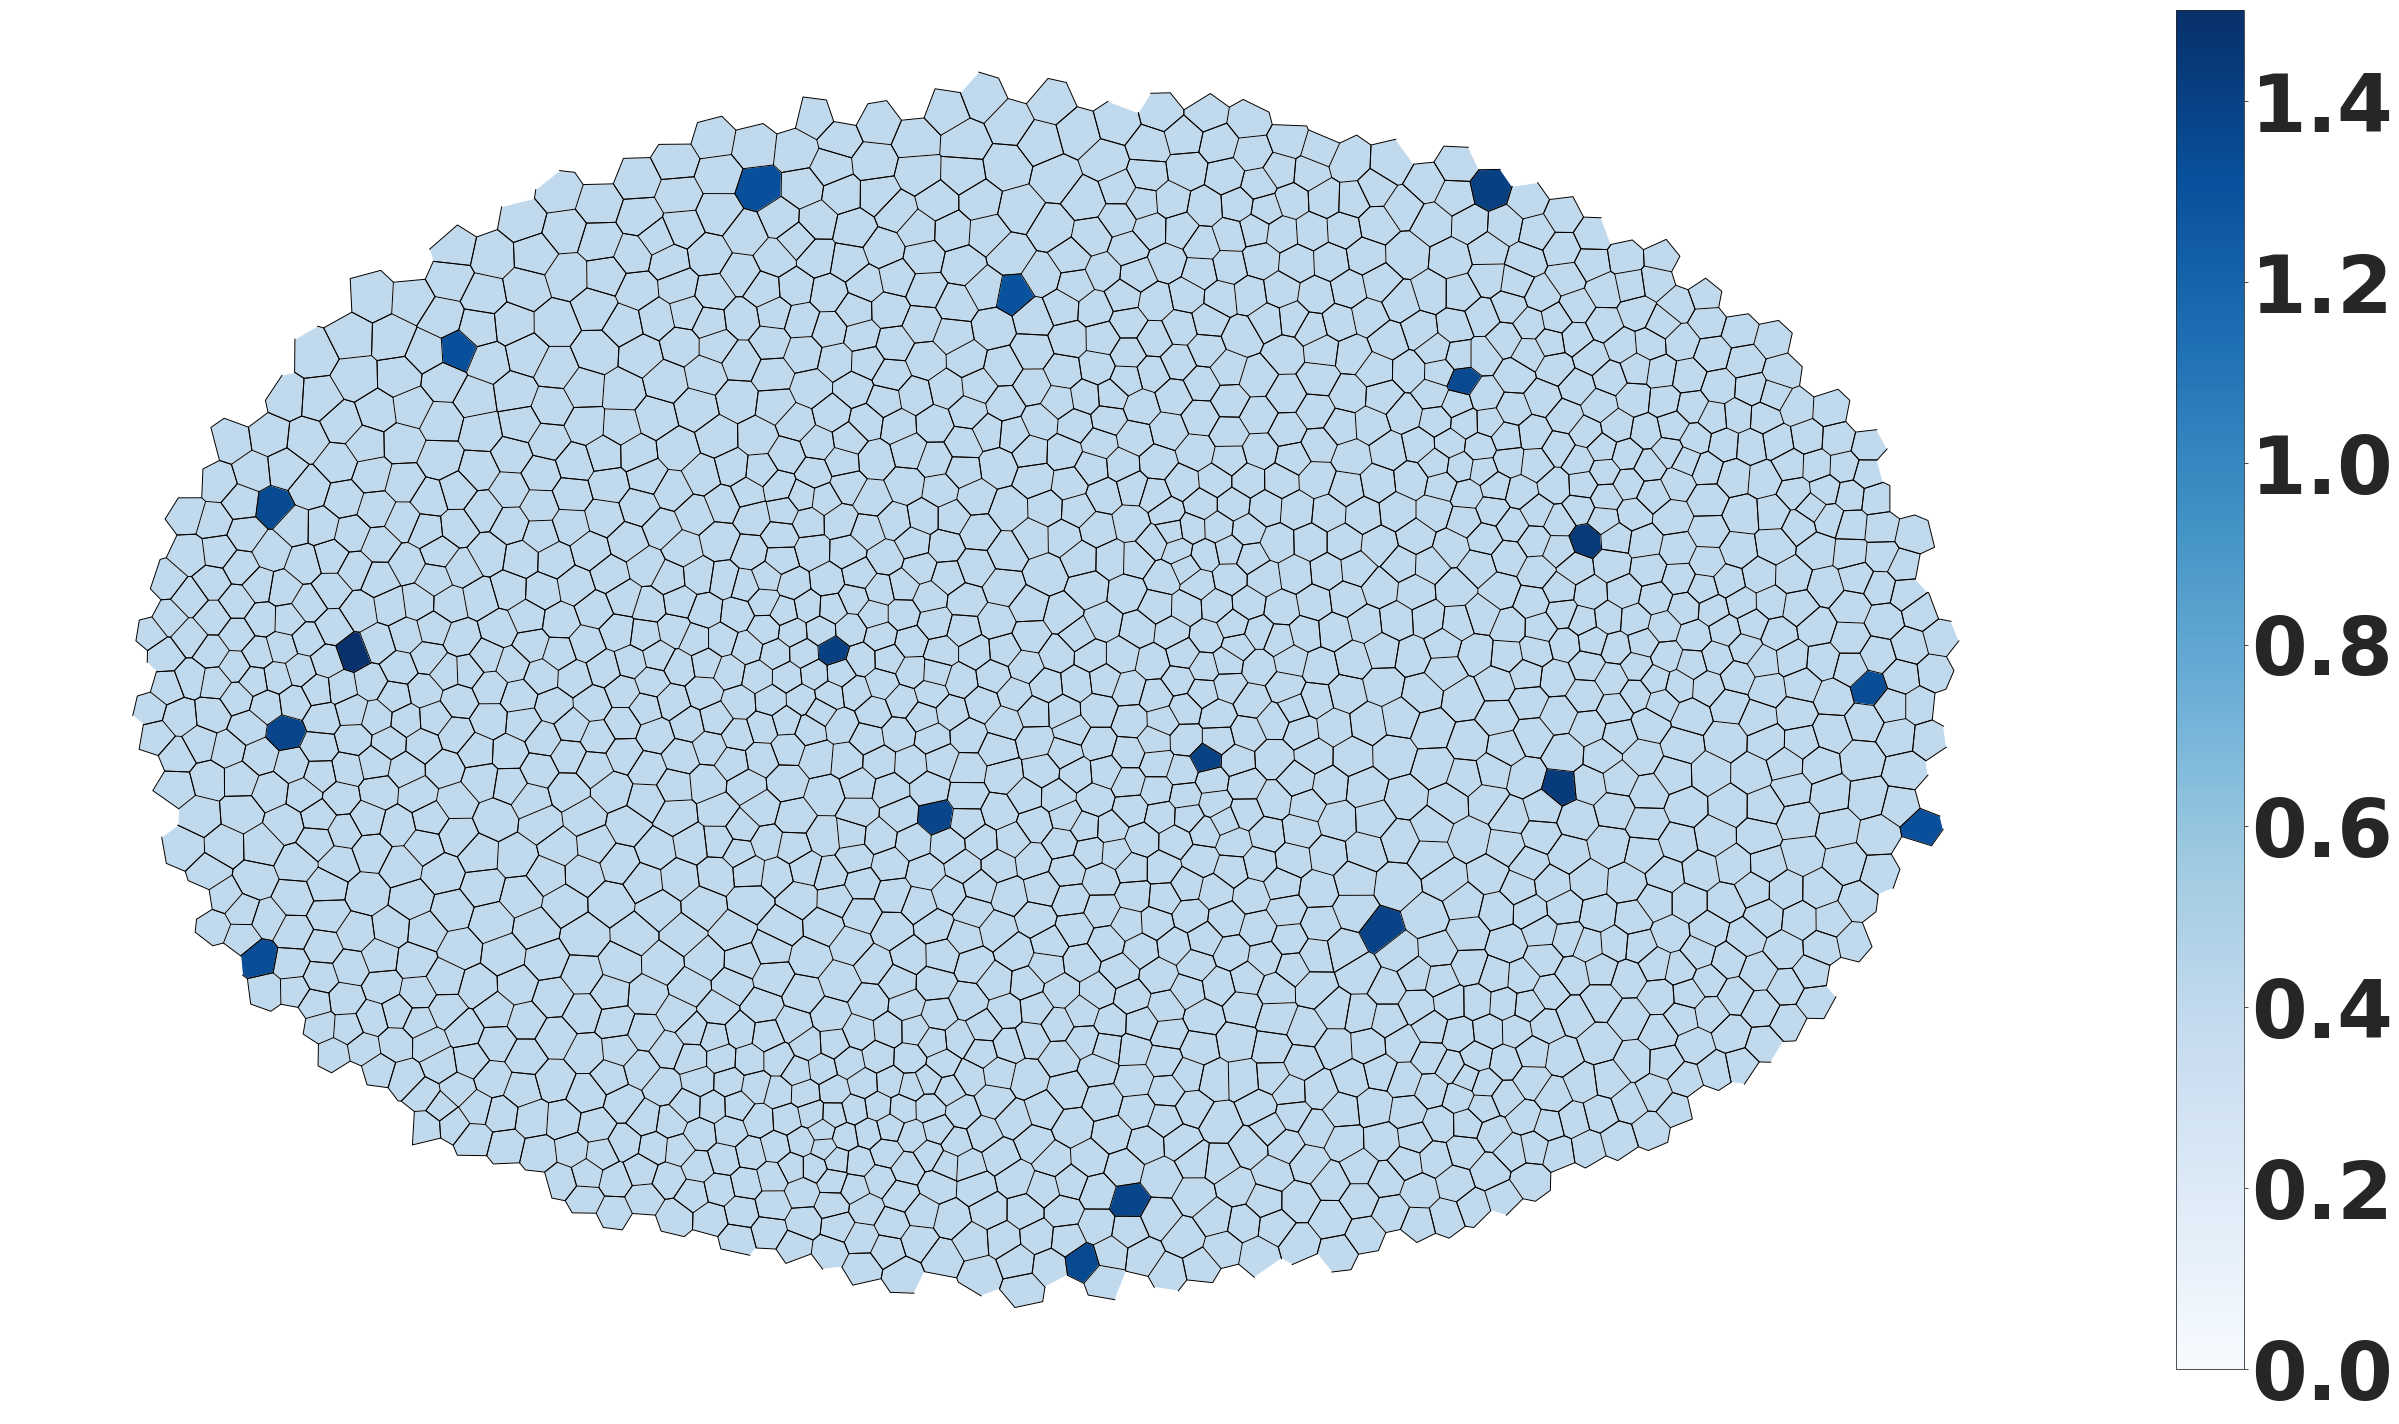

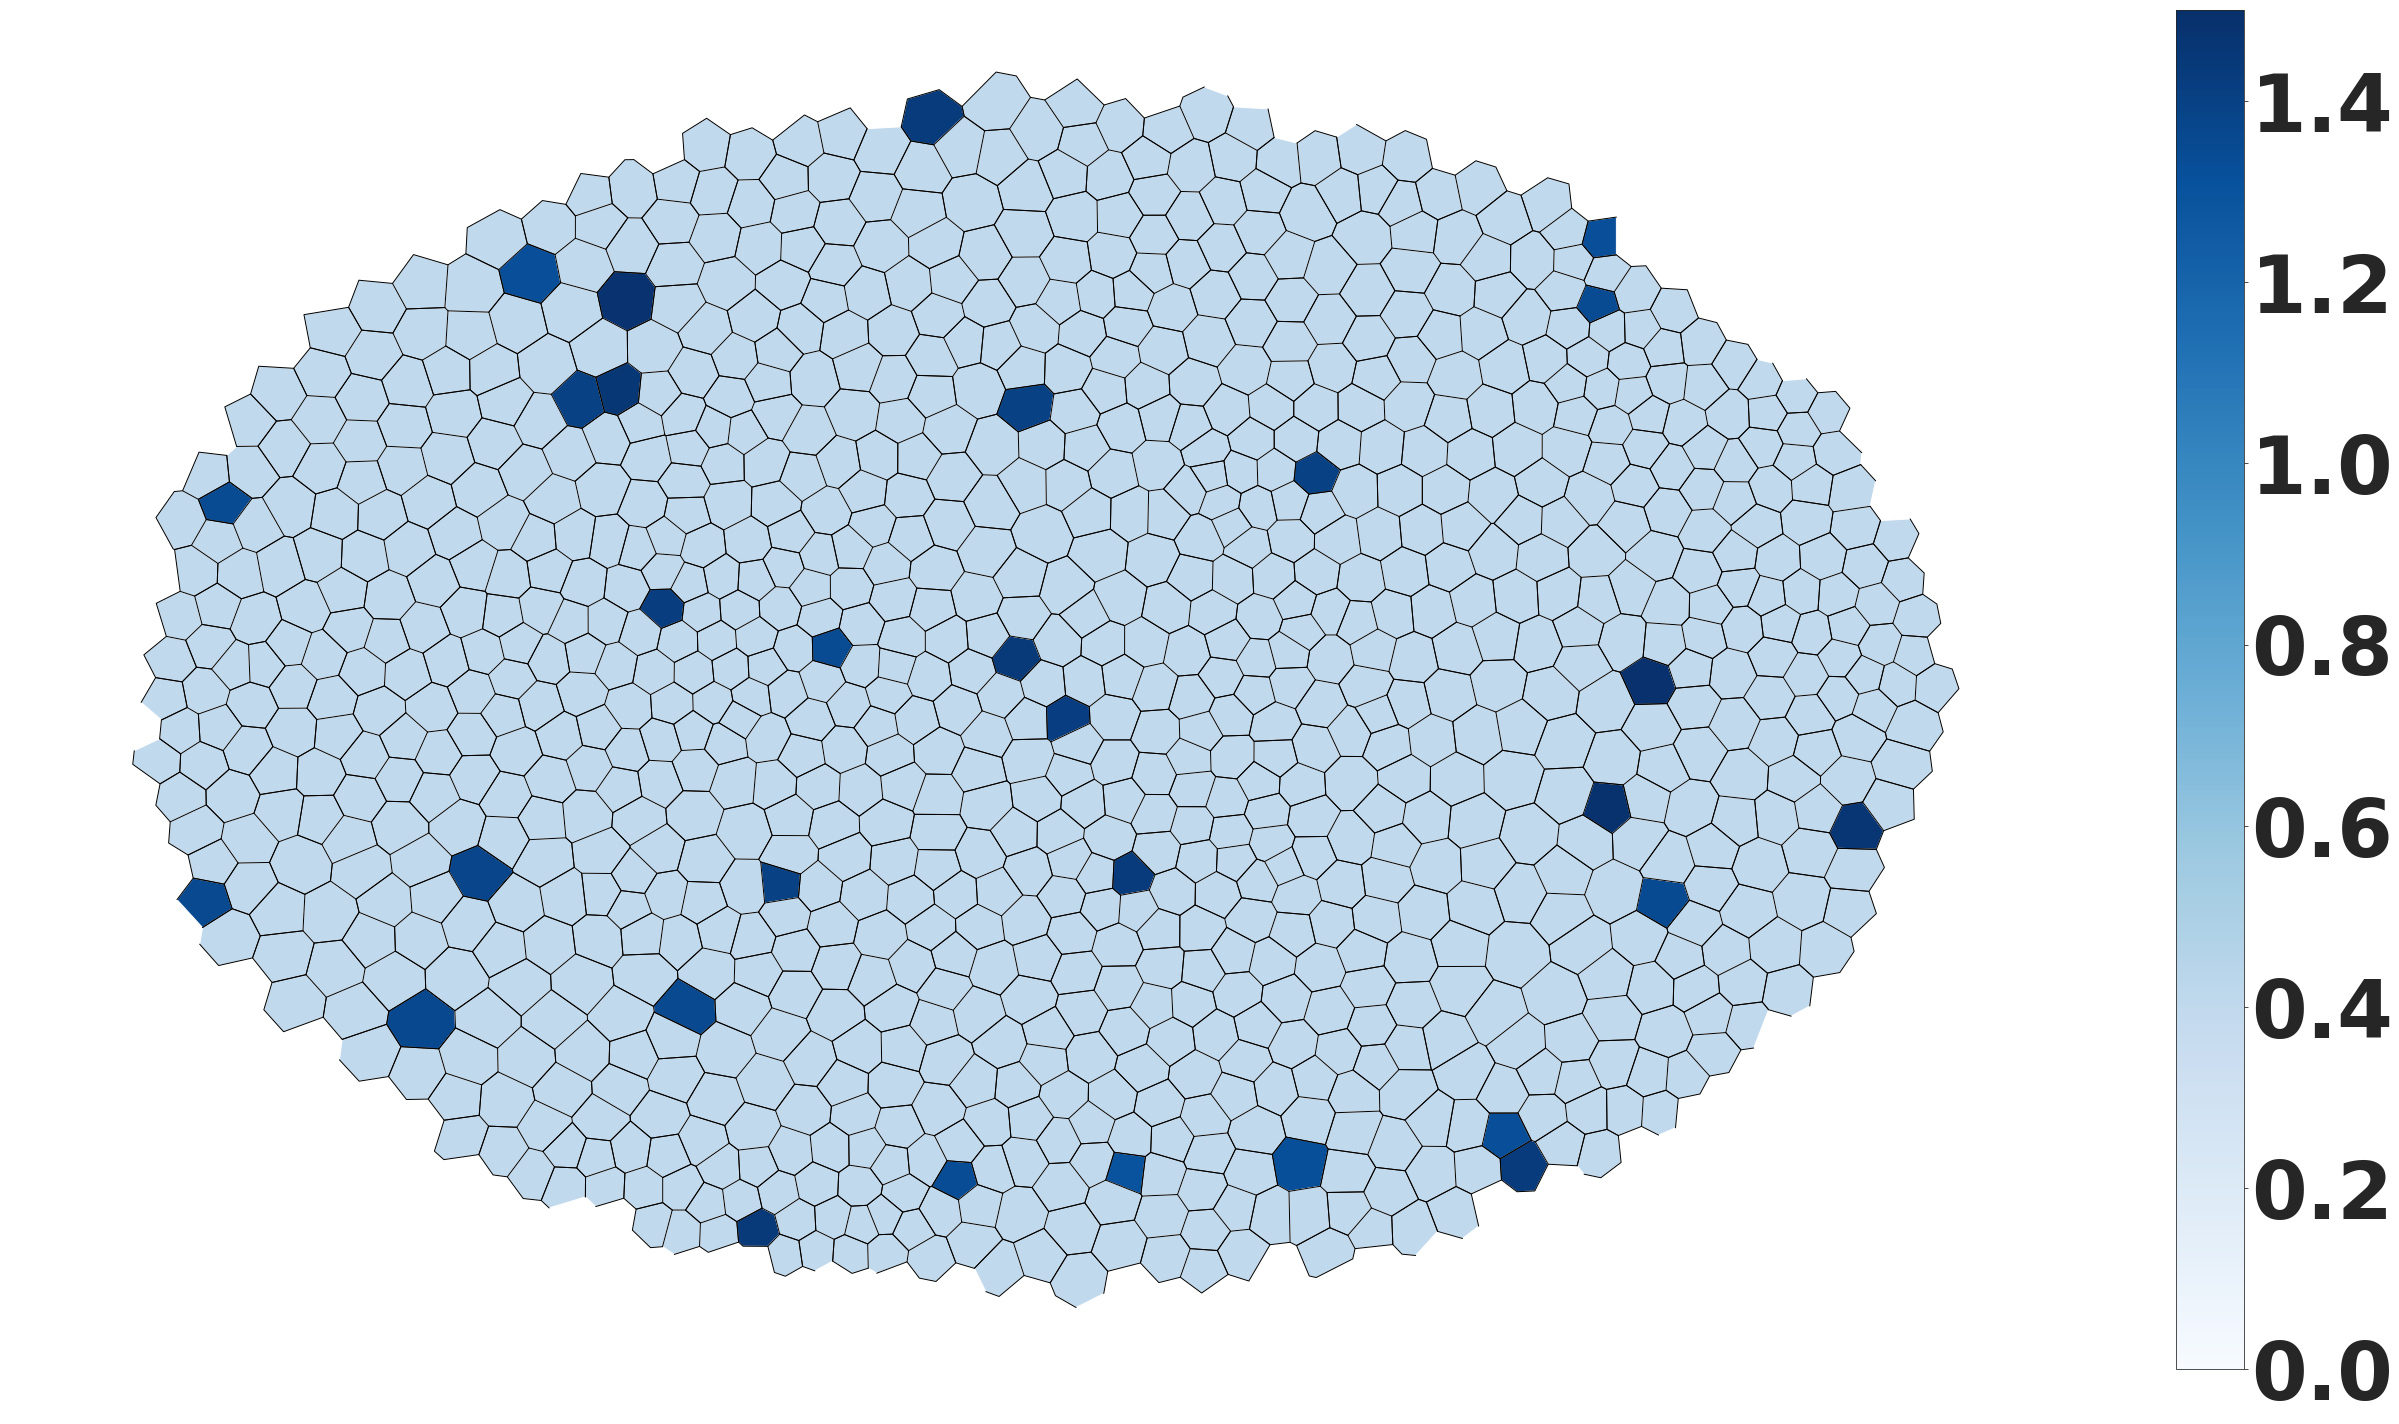

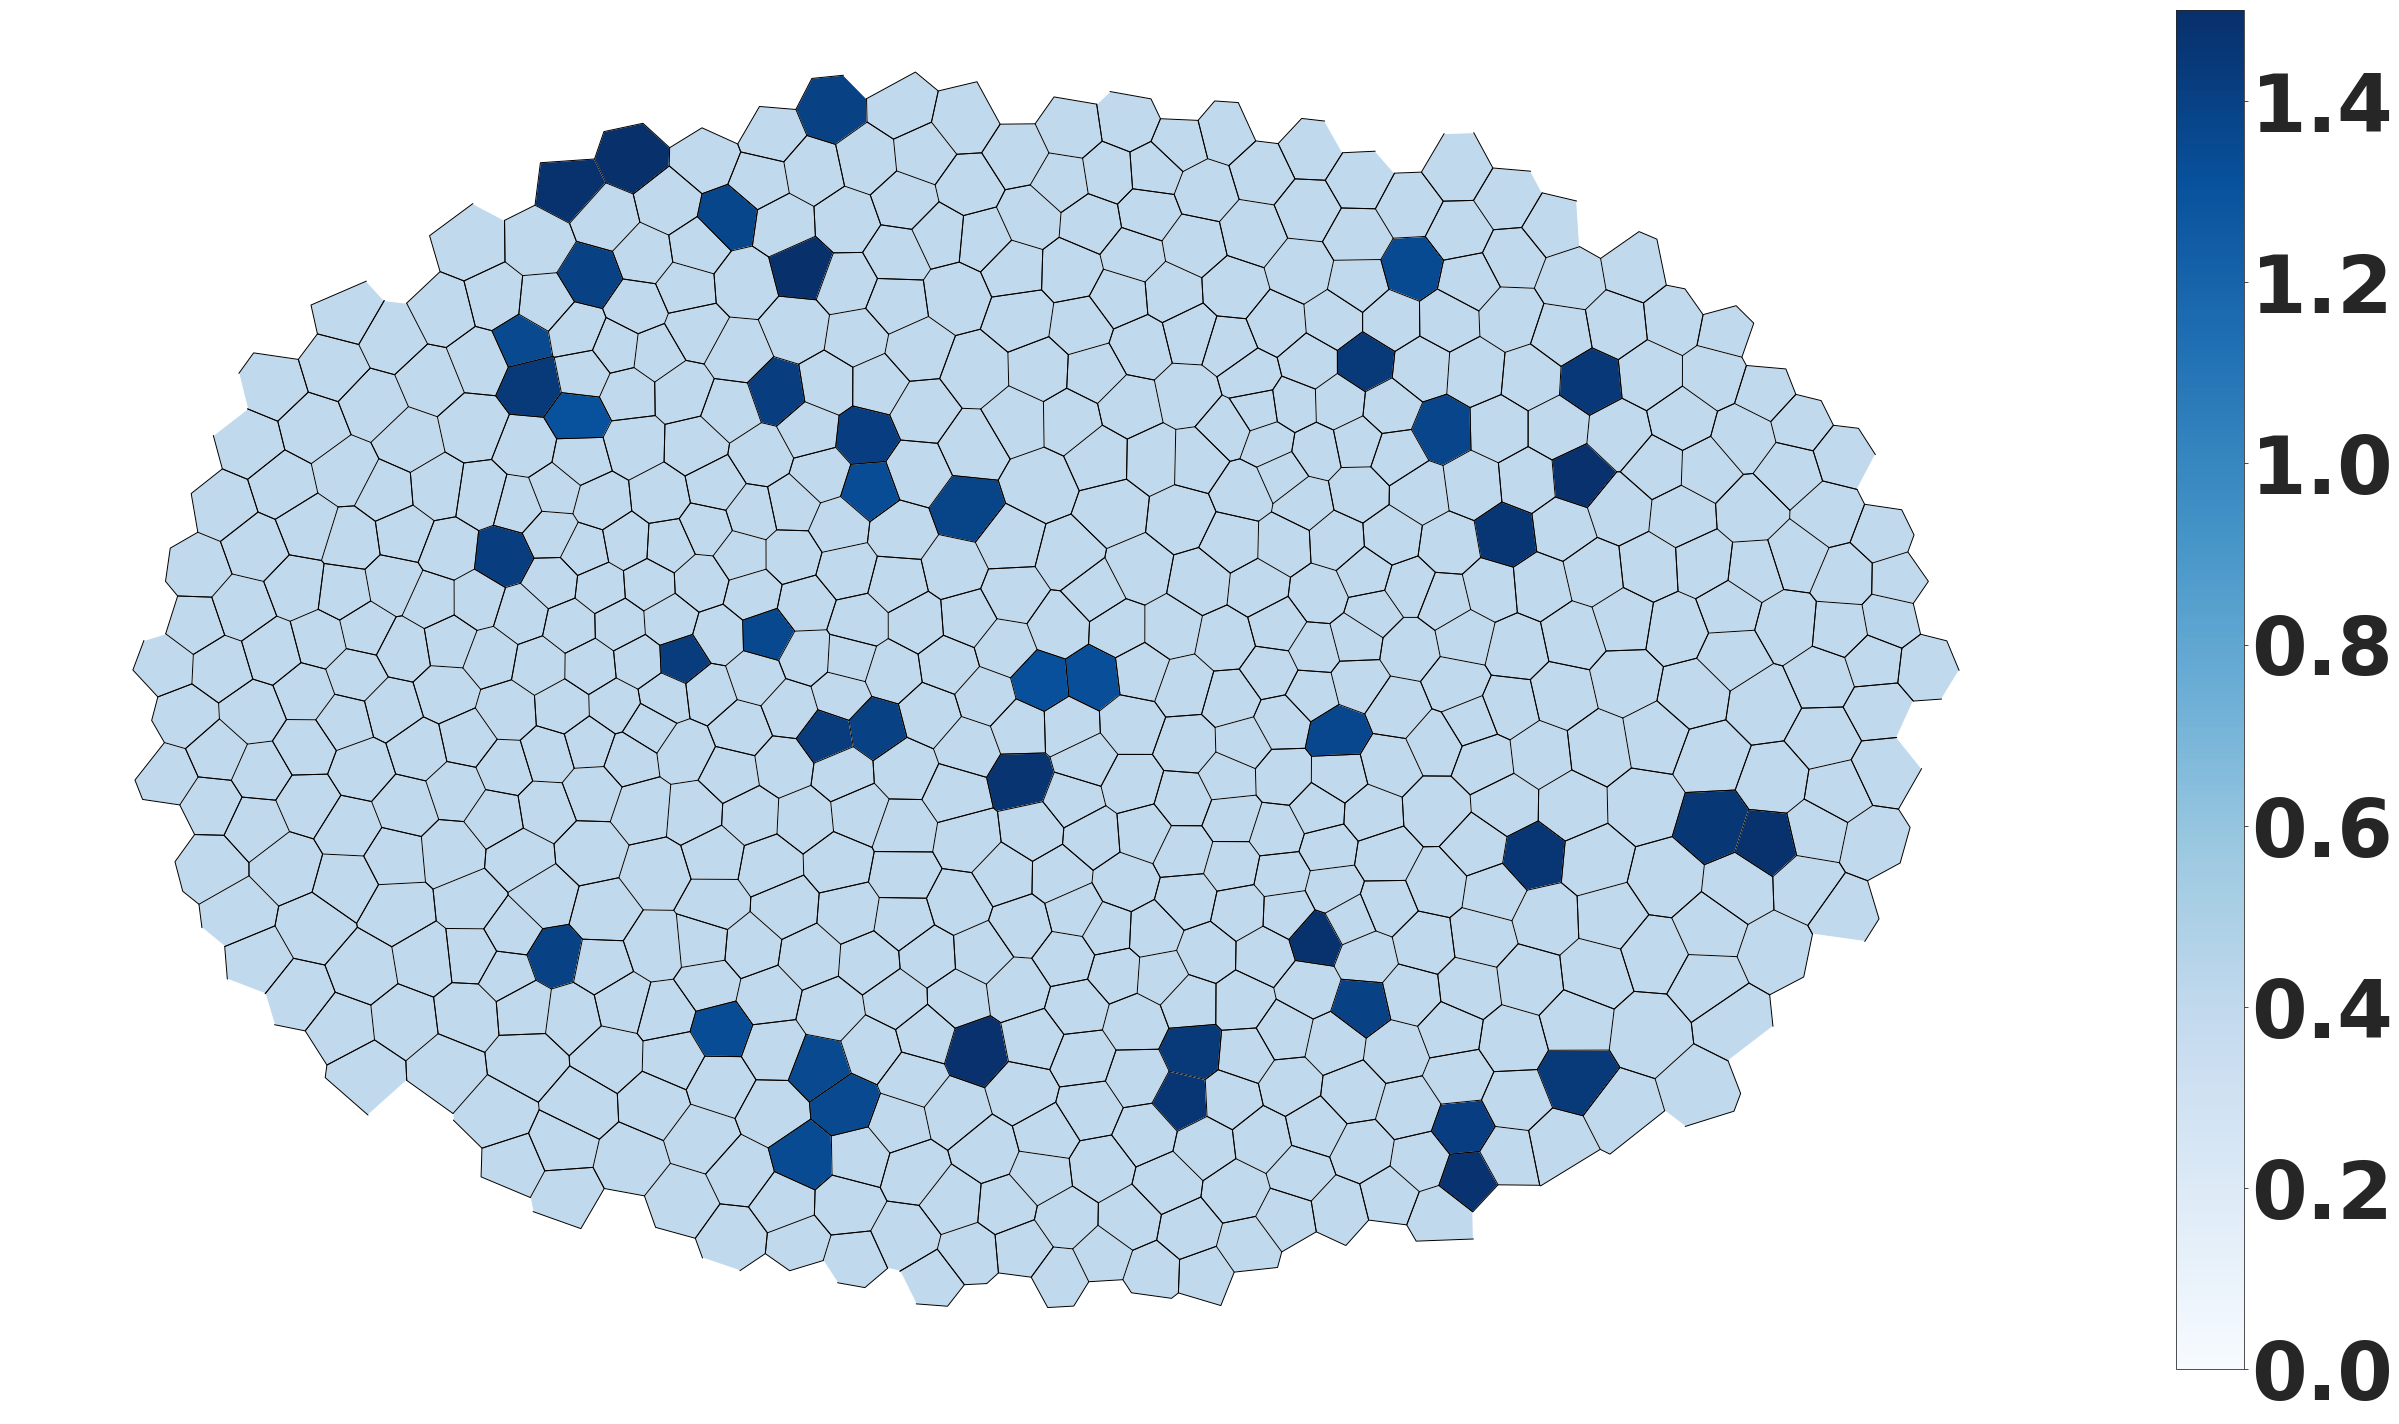

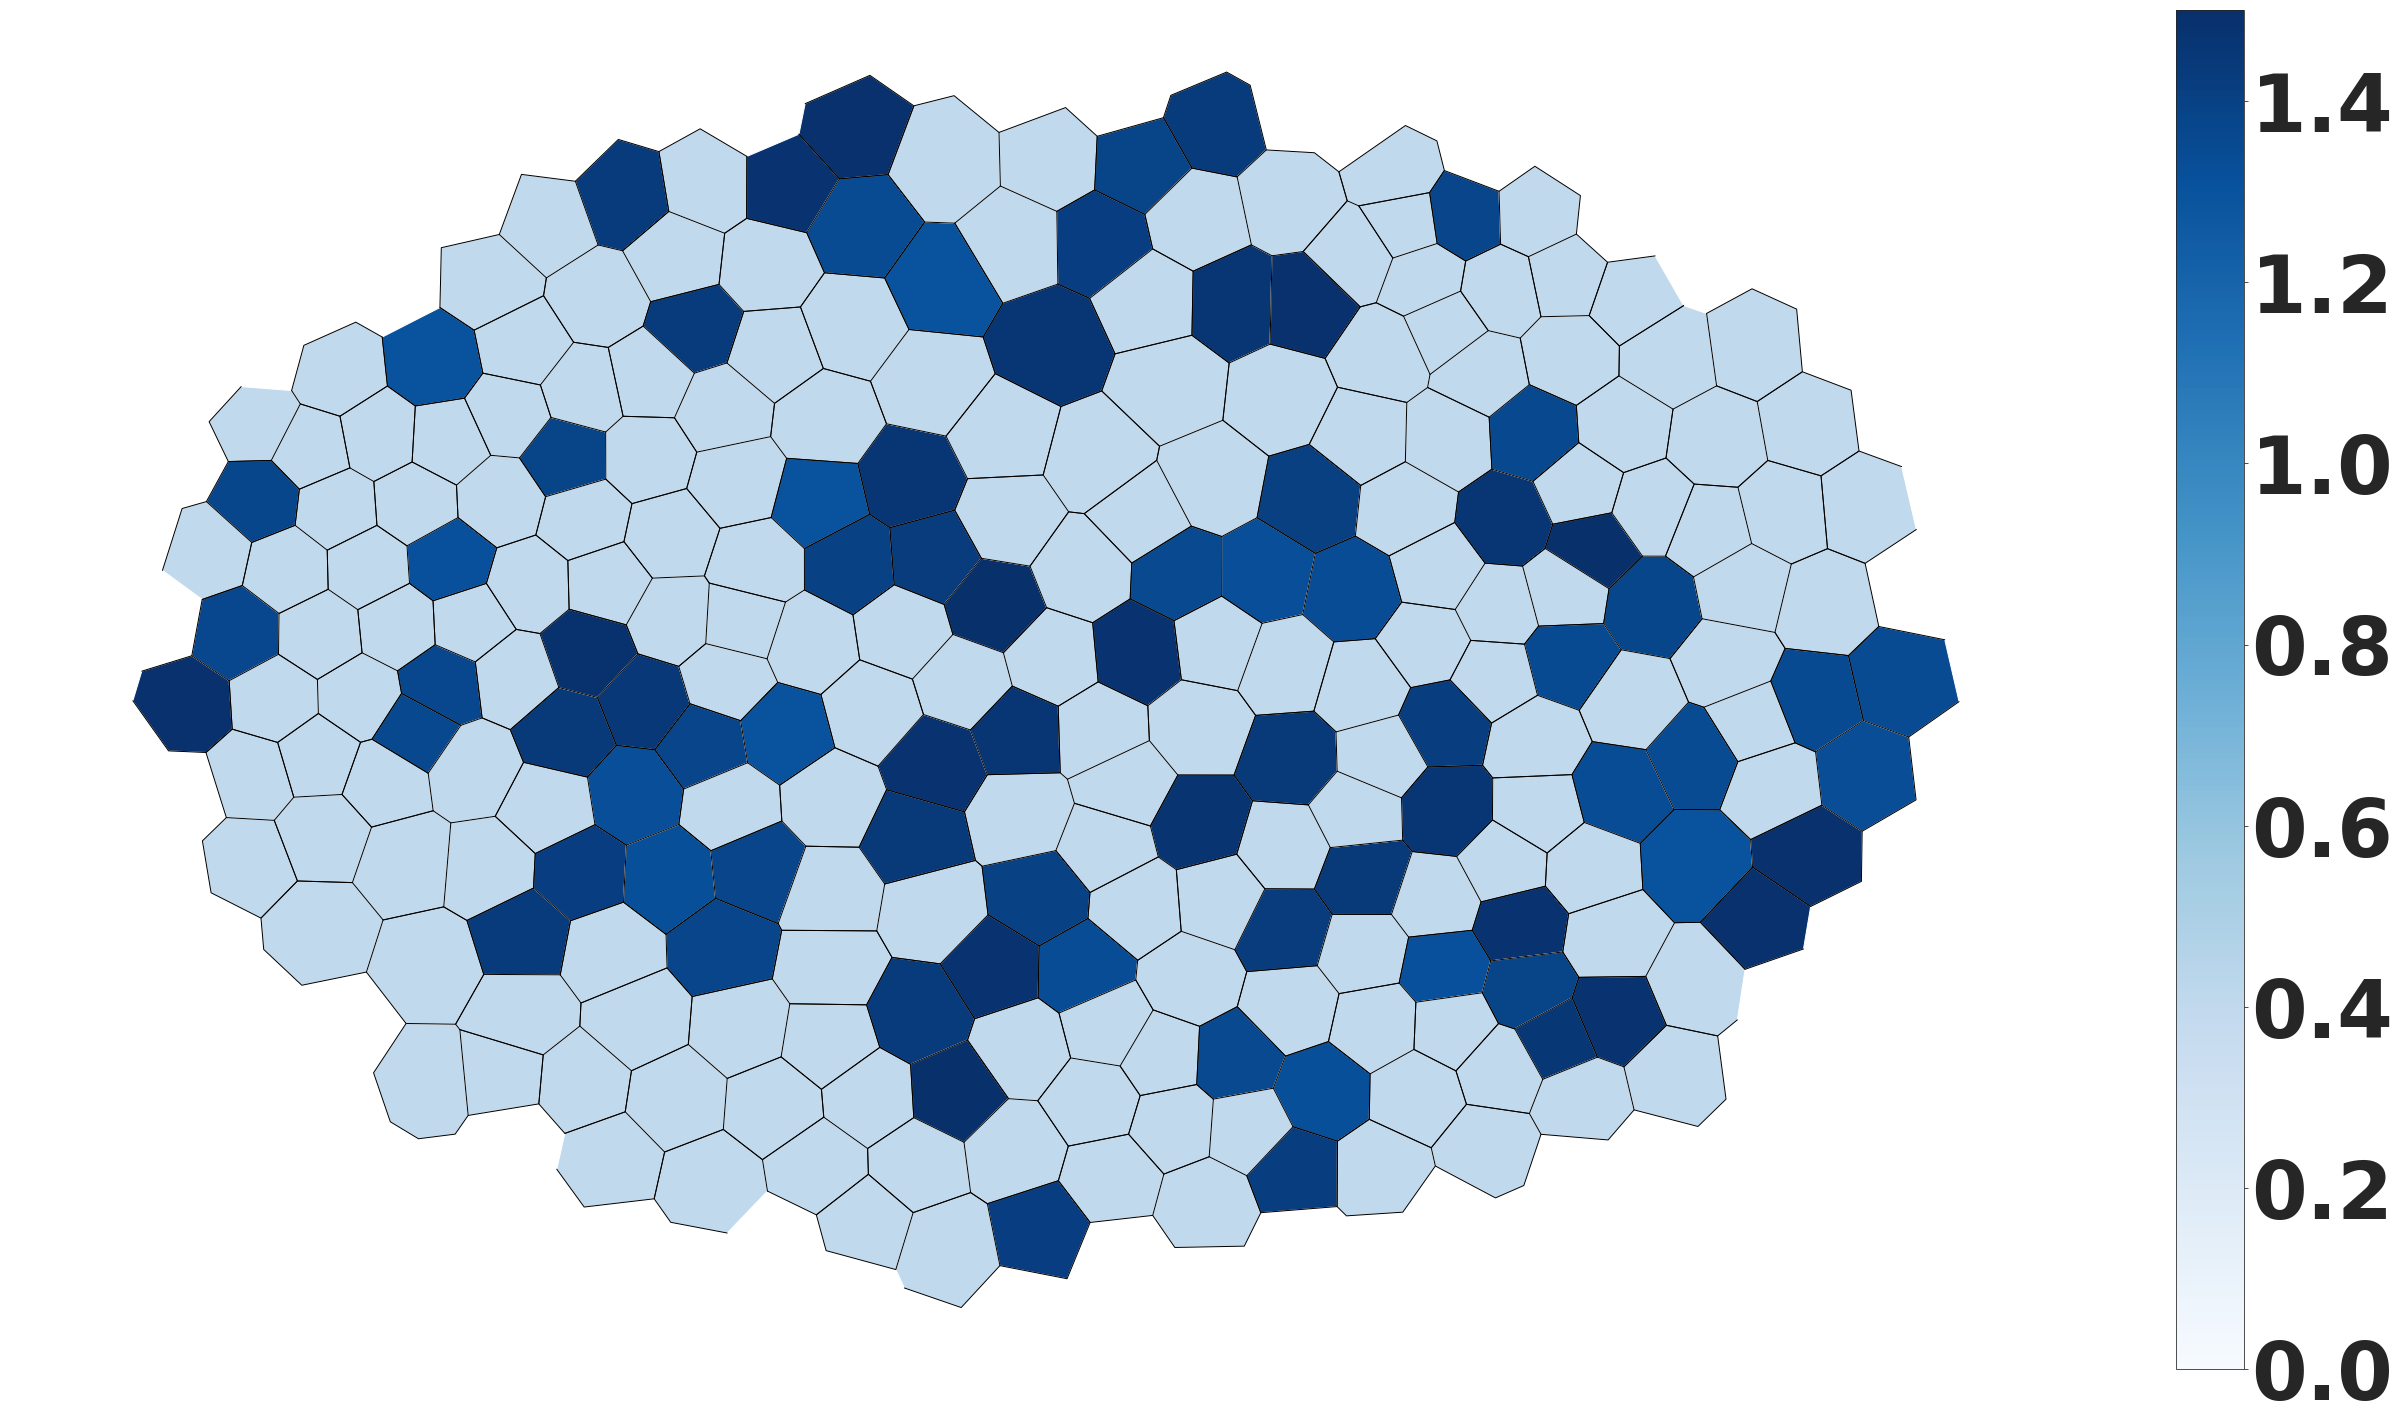

In [8]:
for i in range(0, len(divisionFactors)):
    simPouches[i].draw_profile(saveFolderName)

# Draw the kymograph profiles of the pouches

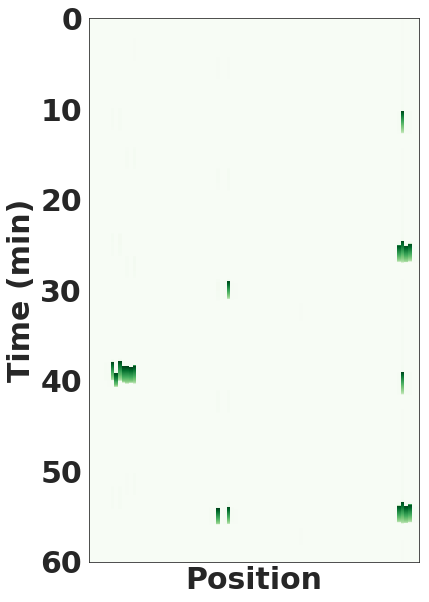

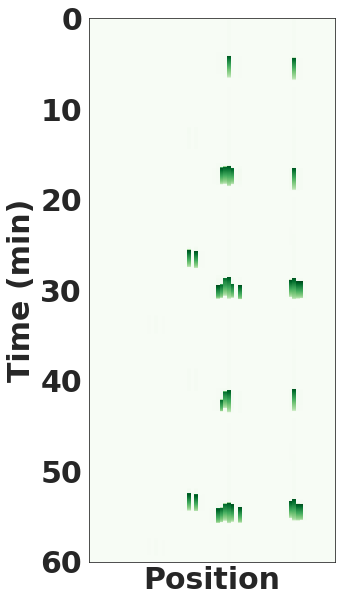

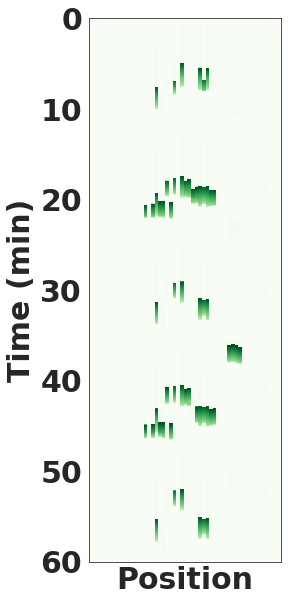

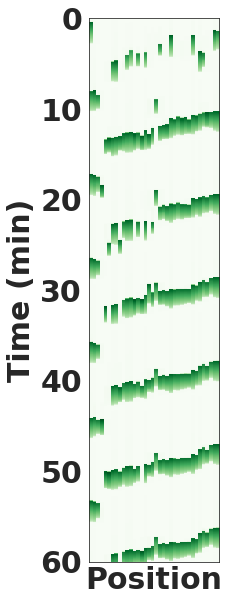

In [9]:
for i in range(0, len(divisionFactors)):
    simPouches[i].draw_kymograph(saveFolderName, kymograph_location=-490)

# Create Video Simulations

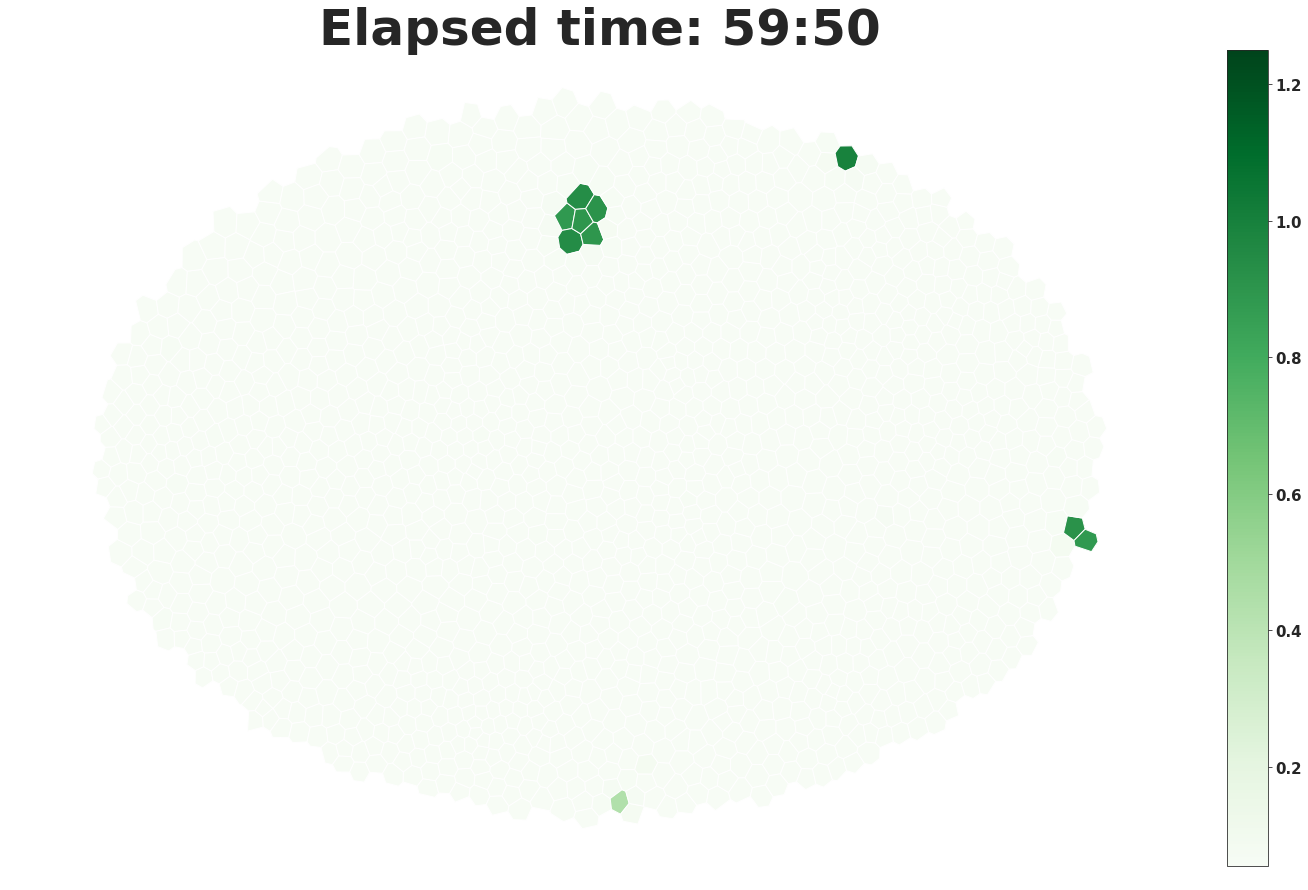

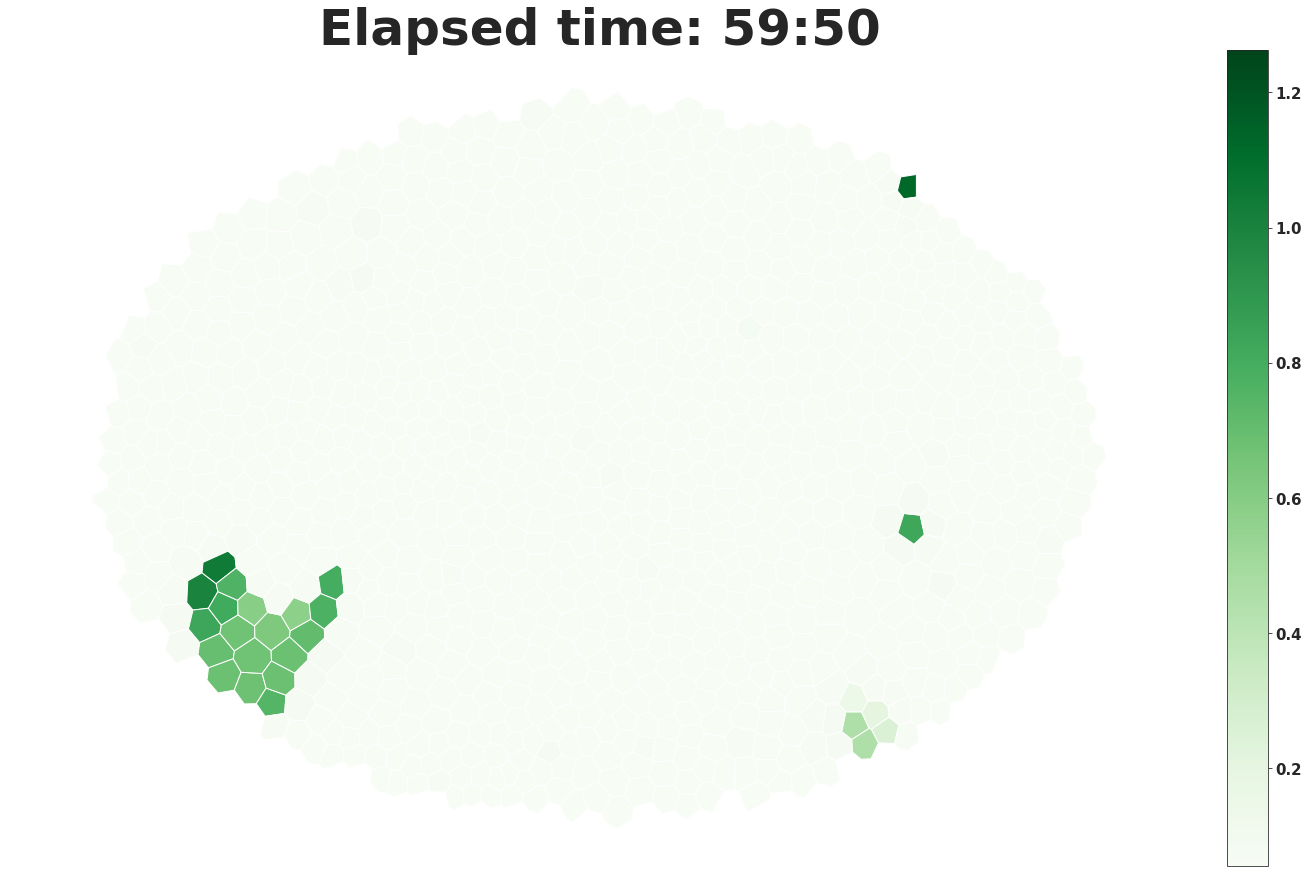

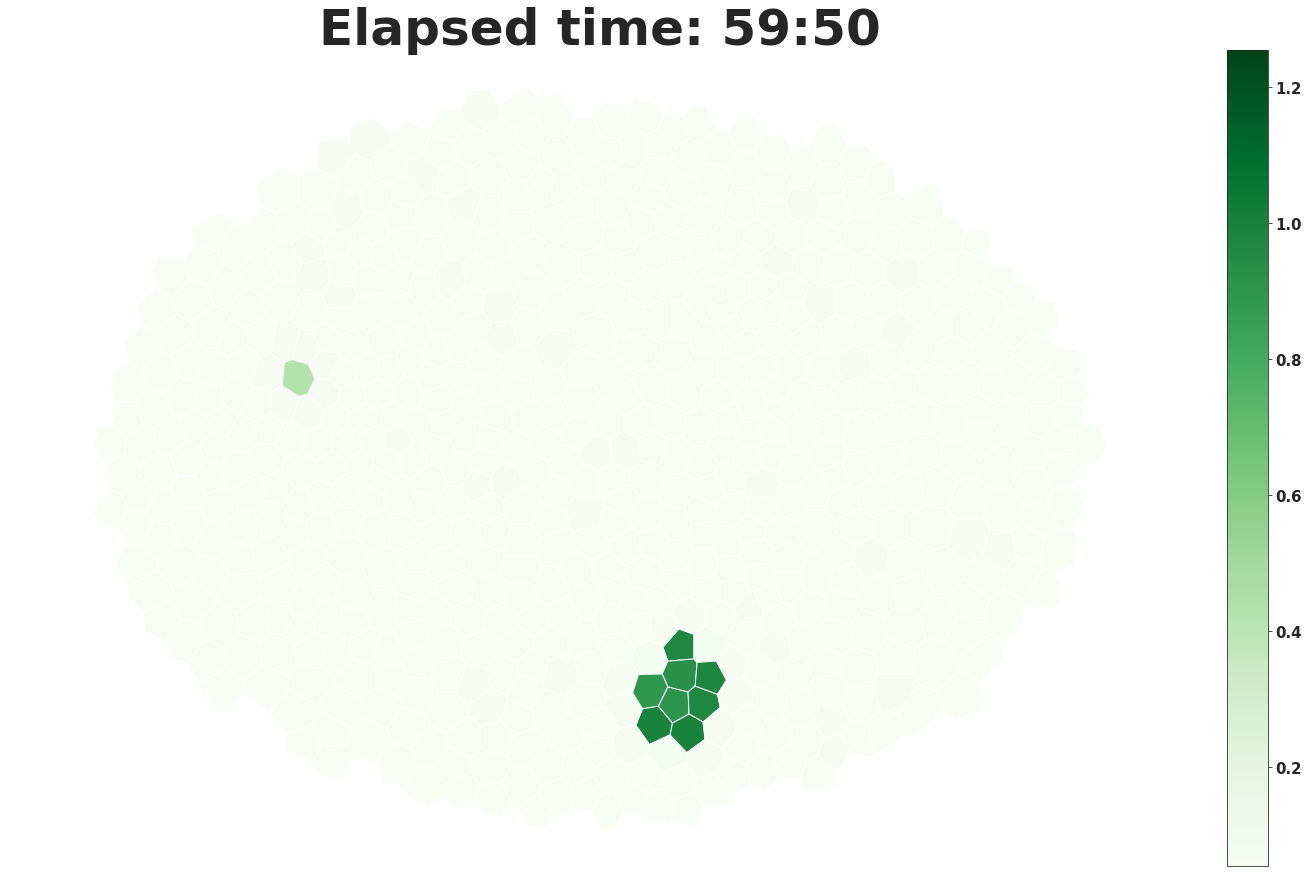

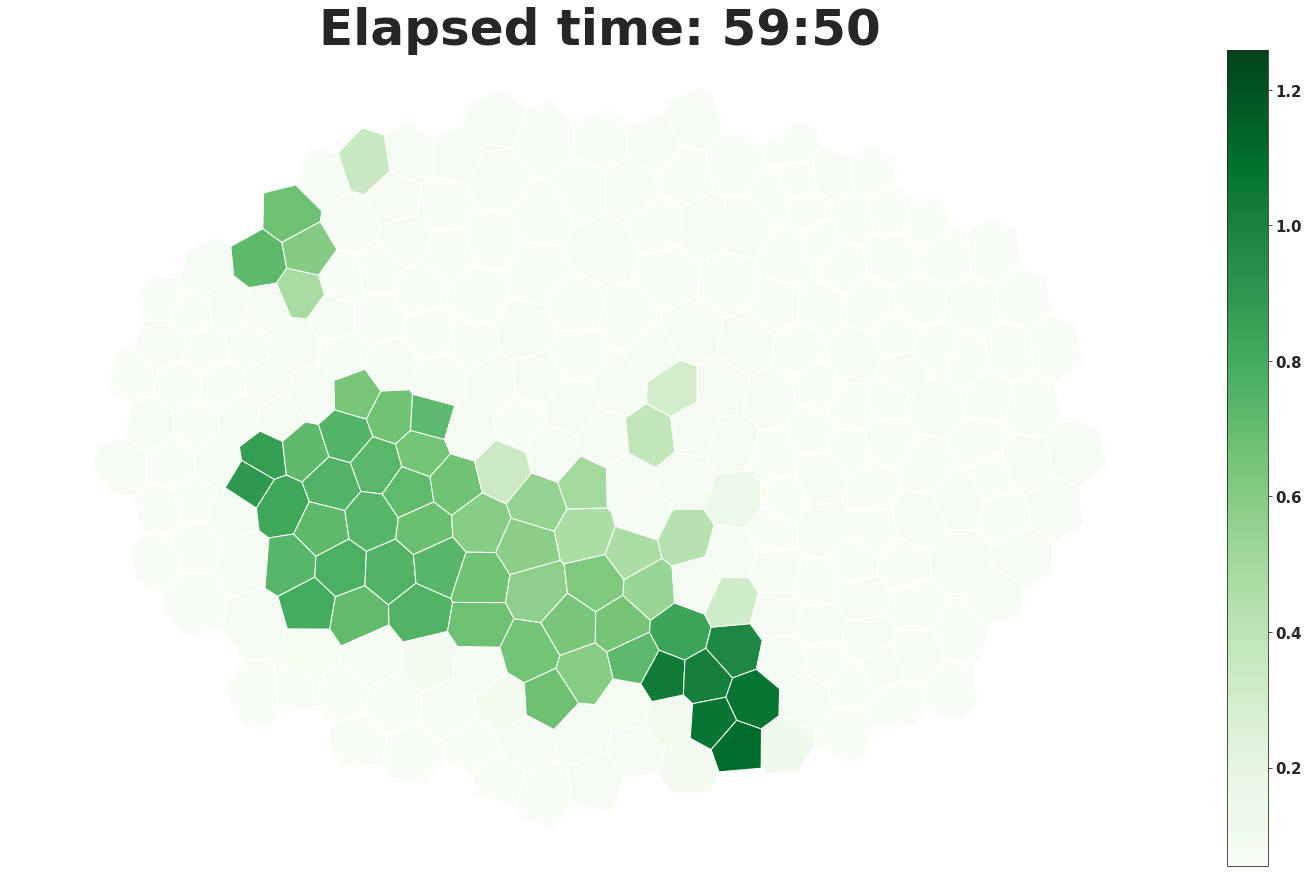

In [10]:
for i in range(0, len(divisionFactors)):
    simPouches[i].make_animation(saveFolderName)